# Notebook for moisture transport project 

**TO DO**

- get hourly data for all variables (new hard disk?)
- solve diagnostic calculation of moisture divergence


**First steps**
- create timeseries with anomalies for P, E and moisture transport (MFC)
- wavelet analysis on hourly precip data 
- decomposition of MFC in eddy and mean flow 
- decomposition in thermodynamic and dynamic component 


**Next steps:**
- do the same for WRF or HAR data 
- do the same for extreme events on different time scales 
- do the same events for extreme events on different spatial scales 


##  vertically integrated moisture flux divergence from q and wind fields 

- get moisture divergent fields for every single summer season and calculate the mean of divergences 
- column integration of divergence fields 
- deviation to monthly means for eddy decomposition 
- from mixing ratio/specific humidity (kg/kg) to mm/day (or kg/m3) using density of dry air: pd = p/RT (ideal gas law )

## Calculation functions

In [1]:
# import libraries 
import numpy as np 
import xarray as xr
import metpy 
from metpy import calc
import scipy as sp
import scipy.signal
from scipy.signal import convolve
import matplotlib.pyplot as plt
import cartopy 
import cartopy.crs as ccrs
import matplotlib.colors as colors

**Basics**

In [30]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def geopotential_to_height(z):
    """ This function converts geopotential heights to geometric heights. This approximation takes into account the varying gravitational force with heights, but neglects latitudinal vairations.
    Parameters:
    ------------
    z(float) : (1D or multi-dimenstional) array with geopotential heights
    Returns:
    ----------
    geometric_heights : array of same shape containing altitudes in metres
    """
    g = 9.80665 # standard gravity 
    Re = 6.371 * 10**6  # earth radius
    geometric_heights   = (z*Re) / (g * Re - z)
    return geometric_heights 


def column_integration(values, z, ax = None ):
    """This functions calculates the column-integrated value of a given atmospheric variable at different pressure levels
    Parameters:
    -----------
    values(float): 1D or multi-dimensional array with values of atmospheric variable at different pressure levels
    z(int): array with geopotential heights for values
    axis = axis along which to integrated. The default is 0.
    Returns:
    --------
    colint(float): array with column-integrated values of variable (dimension reduced by 1)
    """
    # convert geopotential to geometric heights in meters 
    geometric_heights   = geopotential_to_height(z)

    if ax == None:
        ax = 0

    # integration of column values
    colint = np.trapz(values, x= geometric_heights, axis =ax )

    return colint

**Constants**

In [35]:
from metpy.units import units

# assign unit to grid spacing
Rad = 6371*1000
# gravitational accelration 
g = 9.8 
# density of water in kg/m3 
pw= 997
# density for dry air 
pd = 1.225 
# specific gas constant for dry air 
R = 287.058

## grid spacings 
dx = 2*np.pi*Rad * (0.25/360)
# latitude dependent 
dy = 2*np.pi*Rad *(0.25/360) * np.cos(np.nanmean(lats))*(-1)
dx = dx * units.meters
dy = dy * units.meters
# constant for unit in mm per day 
C= -1/(g*pw)
c= -1/(g)

**Divergence**

In [34]:
## preprocessing of coordinates for convolution 

# creating 2D fields for lats and lons 
latitudes = np.stack([lats]*np.shape(lons)[0], axis = 1)
longitudes = np.stack([lons]*np.shape(lats)[0], axis = 0)

# convert lats and lons to cartesian coordinates 
x = Rad * np.cos(np.radians(latitudes)) * np.cos(np.radians(longitudes))
y = Rad * np.cos(np.radians(latitudes)) * np.sin(np.radians(longitudes))
z = Rad *np.sin(np.radians(latitudes))

# stack to get 3D array 
cartesian = np.stack([x, y, z], axis = 2)
# pythagorean theorem to get distances in meter
dlat = np.sqrt(np.sum((cartesian[2:, :] - cartesian[:-2,:]) ** 2, axis=-1))
dlon = np.sqrt(np.sum((cartesian[:, 2:] - cartesian[:,:-2]) ** 2, axis=-1))


In [33]:
# with convolution 

def dy_dlat(y, dlat):
    k_lat = np.array([[-1], [0], [1]])
    result = convolve(y, k_lat, mode="valid") / dlat
    return result 

def dy_dlon(y, dlon):
    k_lon= np.array([[1, 0, -1]])
    result = convolve(y, k_lon, mode="valid") / dlon
    return result 

## Climatological precipitation and evaporation ERA5 

In [32]:
f= 'cache/era5_monthlymean_clim_precip.nc'
precip = xr.open_dataset(f)
P = precip.tp.values[0]*1000
f= 'cache/era5_monthlymean_clim_evapo.nc'
evapo = xr.open_dataset(f)
E = evapo.e.values[0]* - 1000
f= 'cache/era5_monthlymean_clim_moistdiv.nc'
moisture = xr.open_dataset(f)
moistdiv = moisture['p84.162'].values[0] * 86400
vimd = moisture['vimd'].values[0] 
lats = precip.latitude.values
lons = precip.longitude.values

# check P - E which should be equal to moisture flux divergence 
p_e = P - E 

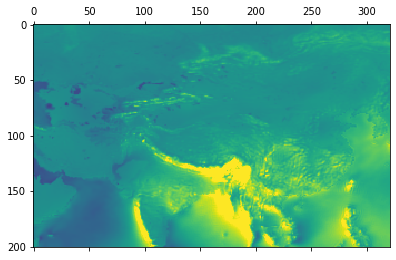

In [15]:
plt.matshow(-vimd, vmin = -10, vmax = 10)

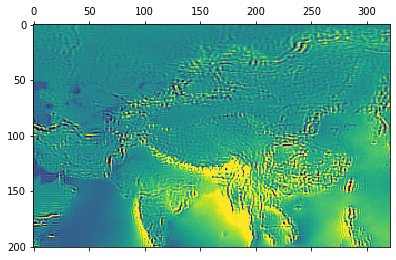

In [16]:
plt.matshow(-moistdiv, vmin = -10, vmax = 10)

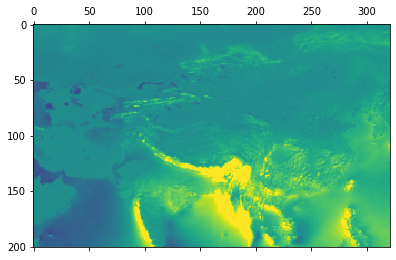

In [17]:
plt.matshow(p_e, vmin = -10, vmax = 10)

In [150]:
mean =(moisture_field/41) * 86400* c
mean.max()

14.013118952985426

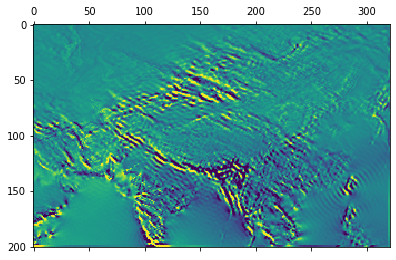

In [146]:
plt.matshow(moisture_field, vmin = -0.01, vmax = 0.01) 

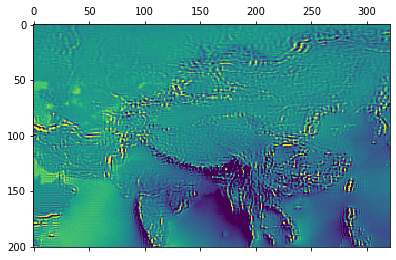

In [145]:
plt.matshow(moistdiv, vmin = -10, vmax = 10)

**Comparison of total sums**

In [2262]:
np.nansum(moistdiv)

-83687.21491231117

In [2261]:
np.nansum(p_e)

85833.61

In [2260]:
np.nansum(vimd)

-90482.31

In [3086]:
# from all years
np.nansum(moist_div)

-31975.445

In [3085]:
# from all years 
np.nansum(flux_div)

-19065.40686281296

In [172]:
## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values

In [2180]:
# summer climatology 

f = 'cache/temp.nc'
data = xr.open_dataset(f)
temp = data.t[0]

f = 'cache/era5_summerclim.nc'
mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
q = mfields.q[0] 
z = mfields.z[0]

lats= mfields.latitude
lons = mfields.longitude
pressure = mfields.level.values

# get qV field 
qu = q*u 
qv = q*v

## 3. Temporal average over summer seasons 1979 to 2019 

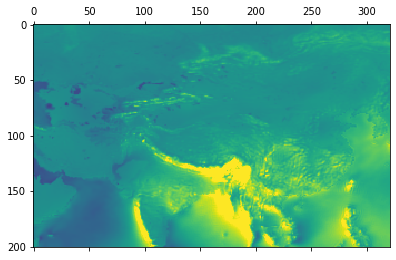

In [134]:
plt.matshow(-vimd, vmin = -10, vmax = 10 )

In [135]:
# based on q 

moisture_field  = np.zeros((201,321))
quint  = np.zeros((201,321))
qvint  = np.zeros((201,321))

for y in np.arange(1979,2020):
    print(y)
    f = 'cache/era5_'+str(y) +'_fields_monmean.nc'
    s = 'cache/era5_'+str(y) +'_clwcciwc.nc'
    t = 'cache/era5_'+str(y) +'_temp.nc'
    pr = 'cache/era5_single-levels-monthly-means_surface_pressure_'+str(y)+'.nc'
    # get variables 
    mfields = xr.open_dataset(f)
    sfield = xr.open_dataset(s)
    tfield = xr.open_dataset(t)
    spdata = xr.open_dataset(pr)
    u = mfields.u[0].values
    v = mfields.v[0].values
    # specific humidity (water vapour in kg/kg)
    q = mfields.q[0].values
    # surface pressure values 
    sp = spdata.sp[0].values /100
    # add specific cloud water and specific cloud ice to get full water 
    clwc = sfield.clwc[0].values
    ciwc = sfield.ciwc[0].values
    q = q +  clwc + ciwc 
    
    z = mfields.z[0].values  
    lats= mfields.latitude.values
    lons = mfields.longitude.values
    pressure = mfields.level.values
    t= tfield.t[0].values
    
    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = find_nearest_idx(pressure, sp_value)
        #if sp_value > pl:
            #idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0
    
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d
        
    # get qV fields 
    qu = q*u
    qv = q*v 
    
    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))
    
    # horizontal divergence (unit: kg/m2/s) 
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])
    # sum derivatives along x and y axis to get divergence 
    moisture_field += (udiv + vdiv)
    
    # close open datasets 
    mfields.close()
    sfield.close()
    tfield.close()
    spdata.close()
    


1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [404]:
mdiv = (moisture_field/41)* 86400 

In [402]:
mdiv.max()

14.013118952985426

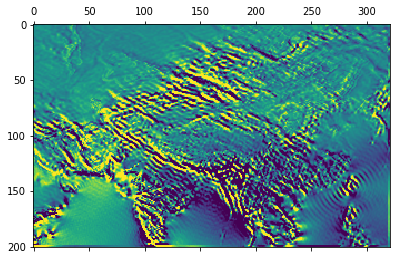

In [405]:
plt.matshow(mdiv, vmin = -10, vmax = 10)

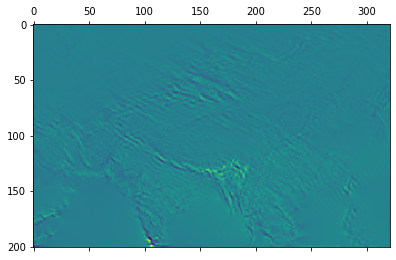

In [173]:
plt.matshow(moisture_field* 86400 * c )

## Example: May 1979 

In [164]:
# Verification: vertically integrated moisture and moisture flux divergence 

f = 'cache/era5_single-levels-monthly-means_1979_months5_mvimdvimdvertical_integral_of_divergence_of_moisture_fluxdivergence_60,50,10,130.nc'
divergence = xr.open_dataset(f)
flux_div = divergence['p84.162'][0] # mean 
moist_div = divergence['vimd'][0] # accumulated 

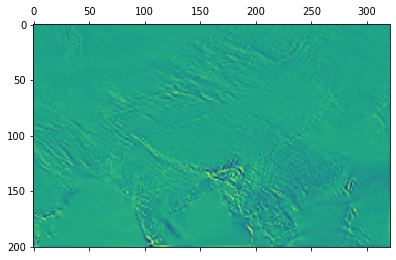

In [142]:
plt.matshow(div)

In [152]:
np.nanmean(div*86400)

-0.5569665329632714

In [151]:
np.nanmean(flux_div*86400)

-0.2954914967655951

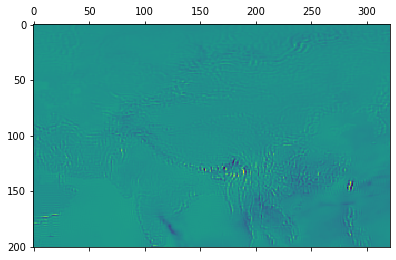

In [143]:
plt.matshow(flux_div)

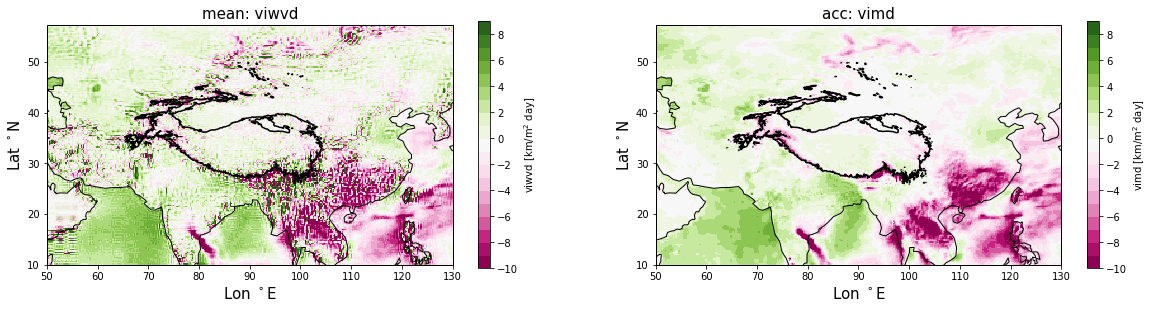

In [99]:

plt.figure(figsize= (20,10))
s= 15


# customizing of colorbar 
cmap=plt.cm.PiYG
#cmap=plt.cm.coolwarm
r = np.arange(-10,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values


ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m1= ax1.pcolormesh(lons, lats, flux_div,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=s)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=s)
ax1.set_title('mean: viwvd', fontsize= s)
plt.colorbar(m1, label = 'viwvd [km/m$^2$ day]')


ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m2= ax2.pcolormesh(lons, lats, moist_div, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_title('acc: vimd', fontsize= s)
ax2.set_ylabel('Lat $^\circ$N',  fontsize= s)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=s)
plt.colorbar(m2, label = 'vimd [km/m$^2$ day]')
plt.savefig('ERA5_vimd_and_viwvd.png')
plt.show()

In [196]:
mfields.close()

f = 'cache/era5_1979_may.nc'
# get variables 
mfields = xr.open_dataset(f)
u = mfields.u[0]
v = mfields.v[0]
# specific humidity (water vapour in g/kg)
sh = mfields.q[0] 
# get geopotential 
z = mfields.z[0].values

# get fields for cloud ice and water 
f = 'cache/1979/era5_pressure-levels-monthly-means_1979_months5_ciwvclwc_60,50,10,130.nc'
d = xr.open_dataset(f)
ciwc = d.ciwc[0]
clwc = d.clwc[0]

# effect of surface pressure
f = 'cache/1979/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
d = xr.open_dataset(f)
sp = d.sp[0].values/100

# temperature for unit conversion 
f = 'cache/1979/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
d = xr.open_dataset(f)
temp = d.t[0].values

q = sh + ciwc + clwc 

In [197]:
# set geopotential to 0, where surface pressure < 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    #if sp_value > pl:
        #idx = idx + 1     
    # set q value below ground to 0 
    q[idx:36, ilat, ilon] = 0

In [198]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*temp[plev])
    m = q[plev] *p_d
    q[plev] = m 

In [199]:
# get qv fields 
qu = q*u
qv = q*v 
 
udiv = np.zeros((37,201,321))
vdiv = np.zeros((37,201,321))

# horizontal divergence
for p in np.arange(37):
    udev = dy_dlon(qu[p], dlon) 
    vdev = dy_dlat(qv[p], dlat) 
    udiv[p] = np.hstack([udev
                         ,np.zeros((201,2))])
    vdiv[p]= np.vstack([vdev, np.zeros((2,321))])

# colummn integration of divergence fields 
quint = column_integration(np.flip(udiv, axis = 0), np.flip(z, axis = 0), ax= 0 )
qvint = column_integration(np.flip(vdiv, axis = 0), np.flip(z, axis = 0), ax = 0 )

# sum derivatives along x and y axis to get divergence 
div= (quint + qvint) 

# x 1/g and conversion to mm per day 
divergence = div * 86400 * c 

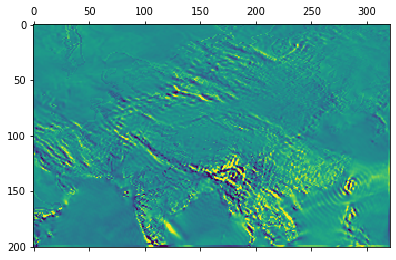

In [129]:
plt.matshow(divergence, vmin = -3, vmax = 3)

In [153]:
# get qv fields 
qu = q*u
qv = q*v 

# colummn integration of divergence fields first
quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0), ax= 0 )
qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0), ax = 0 )

# horizontal divergence

udev = dy_dlon(quint, dlon) 
vdev = dy_dlat(qvint, dlat) 
udiv = np.hstack([udev,np.zeros((201,2))])
vdiv= np.vstack([vdev, np.zeros((2,321))])

# sum derivatives along x and y axis to get divergence 
div= (udiv + vdiv ) 

# x 1/g and conversion to mm per day 
divergence = div * 86400 * c 

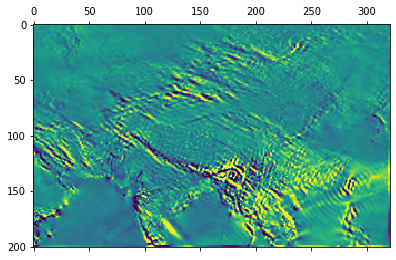

In [106]:
plt.matshow(divergence , vmin = -2, vmax = 2)

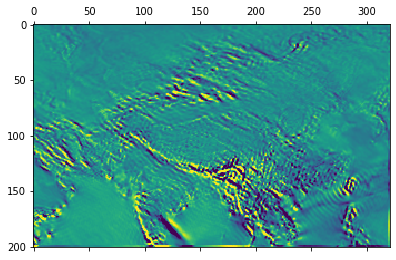

In [114]:
plt.matshow(-diva, vmin = -2, vmax = 2)

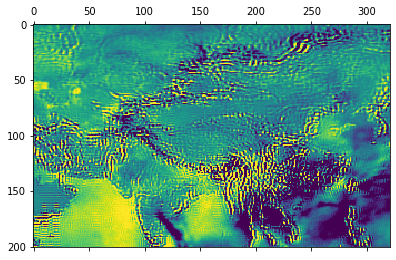

In [113]:
plt.matshow(flux_div, vmin = -5, vmax =5 )

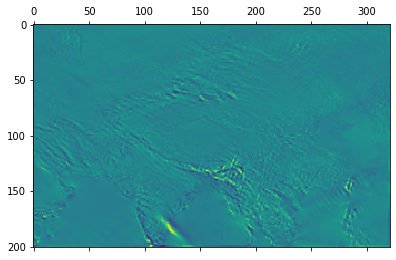

In [208]:
plt.matshow(-mfc*c)

In [220]:
mfd.max()

0.6655248037957869

In [221]:
div_accum.max()

0.598527094030141

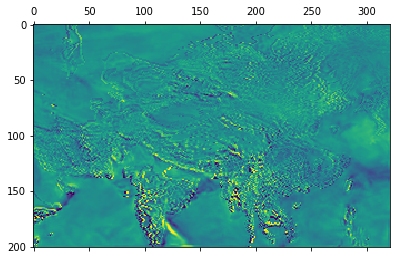

In [201]:
plt.matshow(diva-divergence, vmin = -2,vmax = 2)

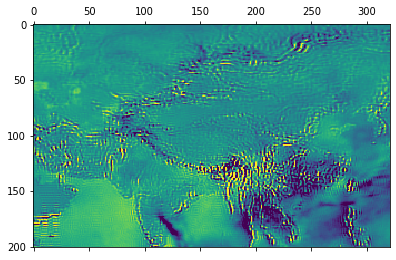

In [71]:
plt.matshow(flux_div, vmin = -10 ,vmax = 10)

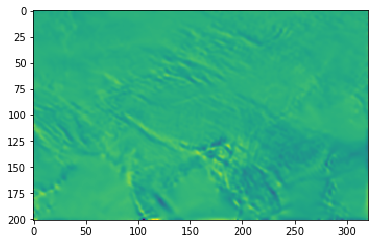

In [114]:
import wrf
smoothed = wrf.smooth2d(-divergence, passes = 5)
plt.imshow(smoothed)

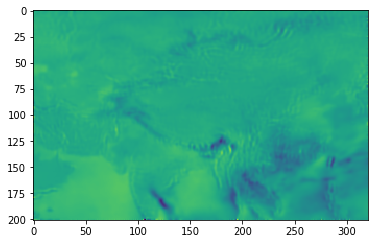

In [115]:
smoothed = wrf.smooth2d(flux_div, passes = 5)
plt.imshow(smoothed)

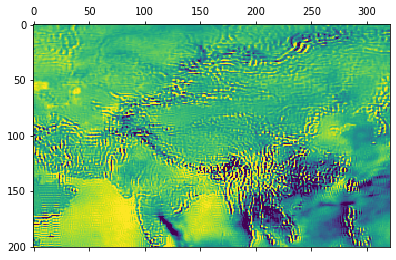

In [2830]:
plt.matshow(flux_div, vmin  = -10, vmax =5)
plt.show()

In [72]:
plt.imshow(moist_div, vmin = -10, vmax = 10)

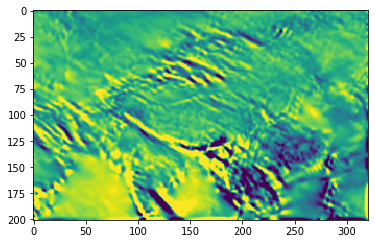

In [179]:
import wrf 
smoothed = wrf.smooth2d(diva, passes = 5)
plt.imshow(smoothed, vmin = -10, vmax = 5)

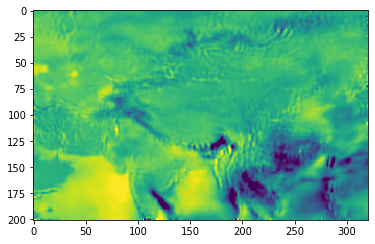

In [2475]:
import wrf 
smoothed = wrf.smooth2d(flux_div, passes = 5)
plt.imshow(smoothed, vmin = -10, vmax = 5)

In [2572]:
# with metpy derivate function instead of convolution 
u_d = metpy.calc.first_derivative(quint[:,:-1], axis =  -1, delta = dlon* units.meter) 
v_d = metpy.calc.first_derivative(qvint[:-1,:], axis = -2, delta = dlat* units.meter)

u_d = np.hstack([udev,np.zeros((201,2))])
v_d = np.vstack([vdev, np.zeros((2,321))])

md = ( u_d + v_d)*86400*c


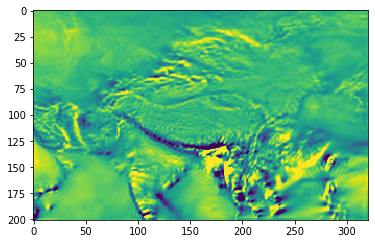

In [2676]:
plt.imshow(div, vmin = -10, vmax = 5)

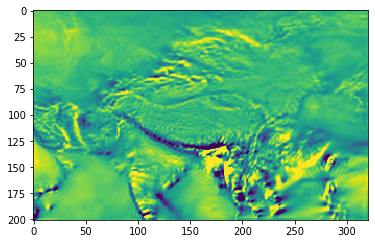

In [2675]:
plt.imshow(-md, vmin = -10, vmax = 5)

-> same result for divergences calculated with convolution for first derivative functions rovided by metpy! 

## May 1979 from hourly data

In [3088]:
# VIMD from may 1979 ERA5 averaged 
file = 'cache/era5_single-levels-monthly-means_1979_months5_vimd_60,50,10,130.nc'
fields = xr.open_dataset(file)
vimd = fields.vimd[0] 

In [76]:
mfields.close()
# file with hourly values for pressure levels 
hourly = 'cache/era5_pressure-levels_1979_months5_geopotentialspecific_humidityu_component_of_windv_component_of_wind_60,50,10,130.nc'
# get variables 
mfields = xr.open_dataset(hourly)
udata = mfields.u
vdata = mfields.v
# specific humidity (water vapour in g/kg)
qdata = mfields.q
# get geopotential 
zdata = mfields.z

# get hourly temperatures 
temp_hourly = 'cache/era5_pressure-levels_1979_months5_temperature_60,50,10,130.nc'
tempfield = xr.open_dataset(temp_hourly)
th = tempfield.t

In [246]:
import glob 
files = glob.glob('cache/1979/era5-1979-??-hour??.nc')

quvec = np.zeros(q.shape)
qvvec = np.zeros(q.shape)

# get mean data 
f = 'cache/era5_1979_may.nc'
# get variables 
flds = xr.open_dataset(f)
u_mean = flds.u[0]
v_mean = flds.v[0]
# specific humidity (water vapour in g/kg)
q_mean = flds.q[0] 

# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*temp[plev])
    q_mean[plev] *= p_d
    
for f in files:
    # one hour file at the time 
    data= xr.open_dataset(f)
    u = data.u.values[0]
    v= data.v.values[0]
    q= data.q.values[0]
        
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*temp[plev])
        m = q[plev] *p_d
        q[plev] = m 
        
    # calculate deviations 
    u_prime = u - u_mean.values
    v_prime = v - v_mean.values
    q_prime = q - q_mean.values

    #  calculate product of primes 
    uq = u_prime * q_prime 
    vq = v_prime * q_prime 
        
    # monthly mean 
    qu = q*u
    qv = q*v

    # save monthly mean deviation from mean 
    quvec += (qu + uq)
    qvvec += (qv + vq)

In [186]:
# save as xarray 
xr.DataArray(quvec/744).to_netcdf('cache/qu-primes_1979_05.nc')
xr.DataArray(qvvec/744).to_netcdf('cache/qv-primes_1979_05.nc')

In [187]:
# set geopotential to 0, where surface pressure < 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    #if sp_value > pl:
        #idx = idx + 1     
    # set q value below ground to 0 
    quvec[idx:36, ilat, ilon] = 0
    qvvec[idx:36, ilat, ilon] = 0
    
# column integration    
qu_integrated = column_integration(np.flip(quvec, axis= 0), np.flip(z, axis = 0), ax = 0)    
qv_integrated = column_integration(np.flip(qvvec, axis= 0), np.flip(z, axis = 0), ax = 0)    
    
# divergence calculation 
udev = dy_dlon(qu_integrated, dlon) 
vdev = dy_dlat(qv_integrated, dlat) 
udiv = np.hstack([udev, np.zeros((201,2))])
vdiv = np.vstack([vdev, np.zeros((2,321))])
# sum derivatives along x and y axis to get divergence 
mfd = (udiv + vdiv)


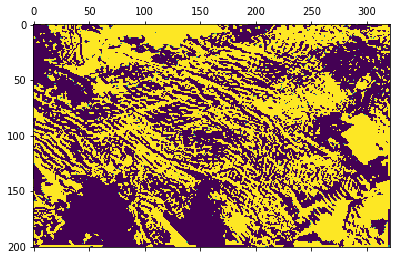

In [245]:
plt.matshow(mfd*86400*c, vmin = -8, vmax = 8)

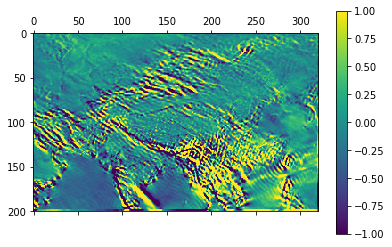

In [242]:
plt.matshow(diva, vmin = -1, vmax = 1)
plt.colorbar()

In [28]:
# get hourly surface pressure data 
hourly_sp = 'cache/era5_single-levels_1979_months5_surface_pressure_60,50,10,130.nc'
spdata = xr.open_dataset(hourly_sp)['sp'].values / 100

In [79]:
# initiate array for divergences 
div_accum = np.zeros((201,321))

for time in np.arange(744):
    if time % 50 == 0:
        print(time)
    q= qdata[time,:,:,:]
    u= udata[time, :, :, :]
    v = vdata[time, :, :, :]
    z= zdata[time, :, :, :]
    sp = spdata[time, :, :]
    t = th[time, :, :, :]
    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)
    
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0
    
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *= p_d
    
    # get qv fields 
    qu = q*u
    qv = q*v

    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # horizontal divergence
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev,np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    div_accum += (udiv + vdiv)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700


In [95]:
diva = (div_accum/744)*86400*c
diva.max()

8.588024552399519

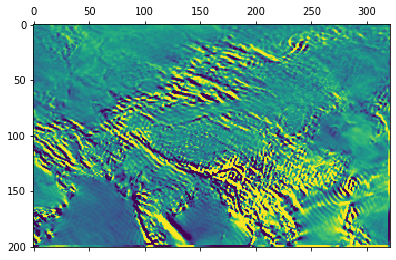

In [81]:
plt.matshow(-(div_accum/744)*86400, vmin = -10, vmax = 10)

In [3135]:
# initiate array for divergences without Z correction 
div_noZ = np.zeros((201,321))

for t in np.arange(744):
    q= qdata[t,:,:,:]
    u= udata[t, :, :, :]
    v = vdata[t, :, :, :]
    z= zdata[t, :, :, :]
    sp = spdata[t, :, :]
    
    # get qv fields 
    qu = q*u
    qv = q*v

    # colummn integration of q and wind fields 
    quint = column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # horizontal divergence
    udev = dy_dlon(quint, dlon) 
    vdev = dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev,np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    div_noZ += (udiv + vdiv)


In [ ]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*th[plev])
    m = q[plev] *p_d
    q[plev] = m 
        

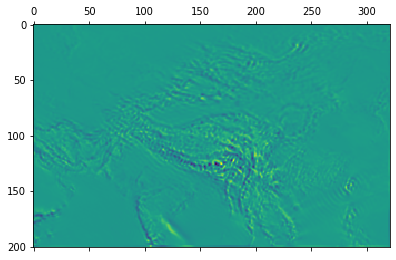

In [3163]:
# accumulated divergence field 
plt.matshow(div_accum)

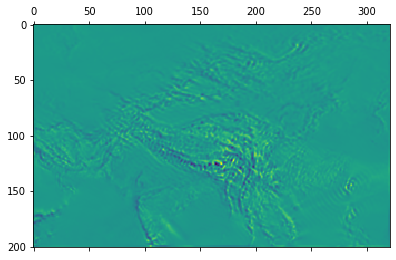

In [3164]:
plt.matshow(div)

In [167]:
diva = (div_accum /744) * 86400 


In [170]:
diva.max()

69.50637220995186

In [3225]:
divm.mean()

3.0535584230642054e-06

## Plot water balance 

NameError: name 'mdiv' is not defined

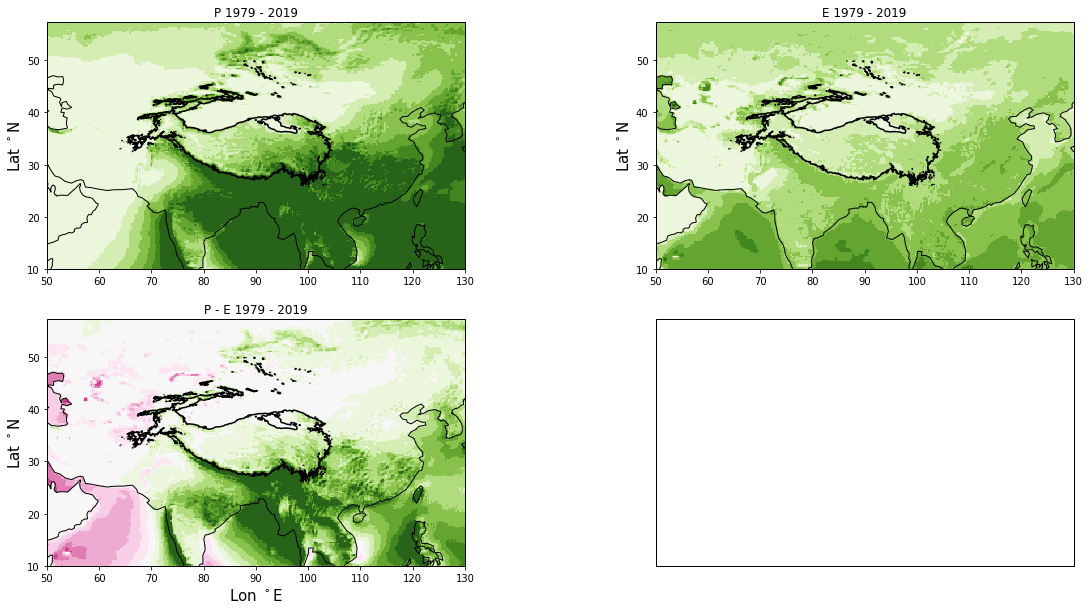

In [174]:
fig =plt.figure(figsize=(20,10))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

# customizing of colorbar 
cmap=plt.cm.PiYG
#cmap=plt.cm.coolwarm
r = np.arange(-8,8)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
lons = precip.longitude.values
lats = precip.latitude.values


# P
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax1.pcolormesh(lons, lats, P,norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title('P 1979 - 2019')
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=15)


# E
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax2.pcolormesh(lons, lats, E, norm = norm, cmap = cmap  )
ax2.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines(color = 'black')
ax2.set_title('E 1979 - 2019')
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=15)


# P - E
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
ax3.pcolormesh(lons, lats, p_e, norm = norm, cmap = cmap  )
ax3.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines(color = 'black')
ax3.set_title('P - E 1979 - 2019')
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=15)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=15)



# moist div 
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])
m = ax4.pcolormesh(lons, lats, -mdiv, cmap = cmap ,norm = norm )
ax4.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines(color = 'black')
ax4.set_title('moisture convergence 1979 - 2019')
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=15)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=15)

cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'mm$^{-day}$')
plt.savefig('plots/P_E_moisture-budget.png')
plt.show()

In [220]:
supersmooth = -(moisture_field/41)*86400*C

In [378]:
smoothed = wrf.smooth2d(mdiv_calculated, passes = 2)

## Decomposition in thermodynamic and dynamic component

## Time series of P, E and moisture transport 

Is summer precipitation variability dominated by moisture transport (remote controls) or by evaporation anomalies (local controls)? --> clearly moisture transport! 

In [23]:
f= 'cache/precip_timeseries.nc'
p = xr.open_dataset(f)
P = p.tp.values[:,0,0]*1000
f= 'cache/evapo_timeseries.nc'
e = xr.open_dataset(f)
E = e.e.values[:,0,0]*-1000
f= 'cache/moistdiv_timeseries.nc'
m = xr.open_dataset(f)
moistdiv = m['vimd'].values[:,0,0]

time = np.arange(1979,2020)

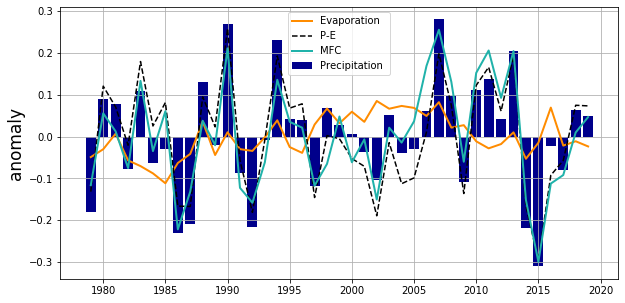

In [70]:
plt.figure(figsize= (10,5))
s= 17

plt.bar( time, P- np.nanmean(P), label = 'Precipitation ', color = 'darkblue')
plt.plot(time, E - np.nanmean(E), label = 'Evaporation', color = 'darkorange', linewidth = 2.0)
plt.plot(time, (P-E ) - np.nanmean(P-E), label = 'P-E', color = 'black', linestyle = '--')
plt.plot(time, -(moistdiv - np.nanmean(moistdiv)), label = 'MFC', color = 'lightseagreen', linewidth= 2.0)
plt.ylabel('anomaly', fontsize = s)
plt.legend()
plt.grid()


plt.savefig('plots/timeseries_p_e_mfc.png')
plt.show()

# Verifications...

## divergence of wind to test divergence calculation 

In [83]:
# read in divergence of wind 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_divergence_of_wind_60,50,10,130.nc'
d = xr.open_dataset(f)['d'][0]

# read in u and v values at pressure levels for same month 
data = 'cache/era5_pressure-levels-monthly-means_1979_months5_uvspecific_humidity_60,50,10,130.nc'
fields = xr.open_dataset(data)
u  = fields.u[0]
v  = fields.v[0]


In [84]:
# choose specific level to look at 
d_lev = d[10, :, :]
u_lev = u[10, :, :]
v_lev = v[10,:, :]

64378221.736385345

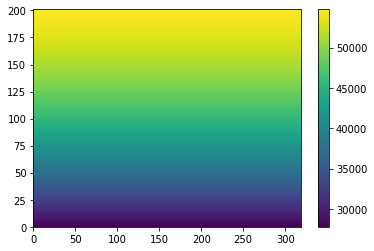

In [44]:
plt.pcolormesh(dlon)
plt.colorbar()
np.var(dlon)

In [85]:
# horizontal divergence
udev = dy_dlon(u_lev, dlon) 
vdev = dy_dlat(v_lev, dlat) 
udiv = np.hstack([udev, np.zeros((201,2)) ])
vdiv = np.vstack([vdev, np.zeros((2,321)) ])

# add 
div_wind = udiv + vdiv

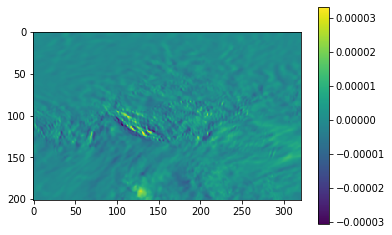

In [86]:
plt.imshow(d_lev)
plt.colorbar()

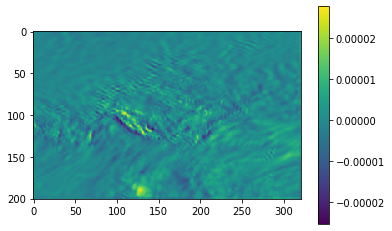

In [87]:
plt.imshow(div_wind)
plt.colorbar()

## test total water column integration 


The column integration function is tested here. Note that two important steps need to e done: 

1. setting z values below surface pressure to 0 
2. convert units of specific humidity from kg/kg to kg/m3

In [37]:
# total column water vapor and divergence
f = 'cache/era5_single-levels-monthly-means_1979_months5_total_column_water_vapourdivergence_60,50,10,130.nc'
d = xr.open_dataset(f)
tcwv = d.tcwv[0].values

# specific humidity 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_uvspecific_humidity_60,50,10,130.nc'
sh = xr.open_dataset(f)
q = sh.q[0].values

# geopotential
f = 'cache/era5_1979_may.nc'
z = xr.open_dataset(f)
z = z.z[0].values

# surface pressure 
f = 'cache/era5_single-levels-monthly-means_1979_months5_surface_pressure_60,50,10,130.nc'
sp = xr.open_dataset(f)
sp = sp.sp[0].values / 100

# temperature 
f = 'cache/era5_pressure-levels-monthly-means_1979_months5_temperature_60,50,10,130.nc'
te = xr.open_dataset(f)
t = te.t[0].values

pressure = sh.level.values 

In [86]:
f = 'cache/era5_single-levels-monthly-means_1979_months5_total_column_water_vapourdivergence_60,50,10,130.nc'
d = xr.open_dataset(f)


In [87]:
# set z to 0 where surface pressure< 1000 hpa 
coords = np.where(sp < 1000)

for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1   
    # set q value below ground to 0 
    q[idx:36, ilat, ilon] =  0

In [88]:
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] = q[plev]* p_d

In [89]:
# column integration of q 
q_integrated = column_integration(np.flip(q, axis= 0), np.flip(z, axis = 0), ax = 0)

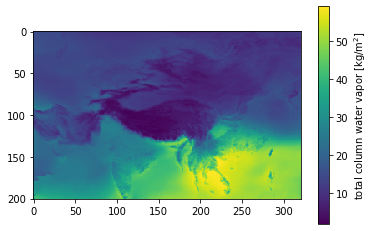

In [90]:
plt.imshow(q_integrated, vmin = tcwv.min(), vmax = tcwv.max())
plt.colorbar(label = 'total column water vapor [kg/m$^2$]')
plt.savefig('column_wv_calculated.png')
plt.show()

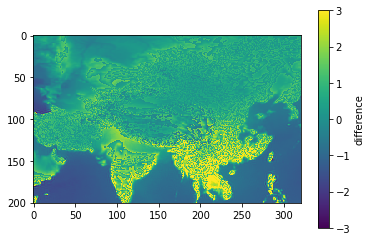

In [91]:
plt.imshow(q_integrated - tcwv, vmin = -3, vmax = 3)
plt.colorbar(label = 'difference')
plt.show()

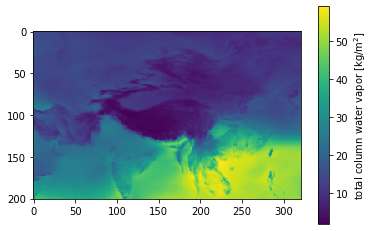

In [208]:
plt.imshow(tcwv,vmin = tcwv.min(), vmax = tcwv.max())
plt.colorbar(label = 'total column water vapor [kg/m$^2$]')
plt.savefig('column_wv_output.png')
plt.show()